# Particle Filter
In this note we look at how to implement a Particle-Filter

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
sense_x=6.613
sense_y=1.9009
sense_theta=-0.0022

state = (sense_x, sense_y, sense_theta)

In [48]:
obs = [(0,0)]*11
obs[0]=(2.1145,5.3793)
obs[1]=(11.0717,-6.3177)
obs[2]=(-19.7459,-2.0209)
obs[3]=(1.8567,-23.4244)
obs[4]=(13.4352,-21.8838)
obs[5]=(29.945,12.6757)
obs[6]=(-13.5573,-36.7337)
obs[7]=(30.2855,-30.9878)
obs[8]=(-36.034,-25.5875)
obs[9]=(22.8732,-41.5321)
obs[10]=(-45.9188,-14.7806)
obs = np.array(obs)

In [19]:
lm = [(0,0)] * 42
lm[0]=(92.064,-34.777)
lm[1]=(61.109,-47.132)
lm[2]=(17.42,-4.5993)
lm[3]=(-7.1285,-34.54)
lm[4]=(232.32,32.032)
lm[5]=(177.43,28.083)
lm[6]=(286.89,18.159)
lm[7]=(274.37,31.197)
lm[8]=(47.484,-36.786)
lm[9]=(69.2,-78.217)
lm[10]=(124.61,24.277)
lm[11]=(36.203,14.827)
lm[12]=(-39.786,-12.615)
lm[13]=(-38.025,-99.976)
lm[14]=(267.33,-14.272)
lm[15]=(28.898,-39.754)
lm[16]=(-29.836,-23.277)
lm[17]=(255.67,9.8137)
lm[18]=(13.452,-72.827)
lm[19]=(102.04,5.1777)
lm[20]=(62.838,1.9057)
lm[21]=(-14.947,-61.919)
lm[22]=(15.162,-97.037)
lm[23]=(36.626,-28.898)
lm[24]=(172.16,-15.217)
lm[25]=(136.95,-14.13)
lm[26]=(-41.714,-61.328)
lm[27]=(39.556,-47.361)
lm[28]=(195.65,8.6677)
lm[29]=(278,13.181)
lm[30]=(151.03,8.9127)
lm[31]=(8.7638,7.5647)
lm[32]=(83.006,20.959)
lm[33]=(205.39,29.686)
lm[34]=(264.51,24.454)
lm[35]=(214.54,-7.8711)
lm[36]=(53.27,-55.233)
lm[37]=(20.139,-20.15)
lm[38]=(8.2018,-20.97)
lm[39]=(-13.641,-0.098341)
lm[40]=(278.92,21.918)
lm[41]=(170.62,28.733)
lm = np.array(lm)

In [7]:
v=3.9611
yawd=3.0937

In [44]:
def init_particles(state, sigma_pos, N):
    particles = []
    noise = np.random.normal(0.0,1.0, size=(N,3))
    for i in range(N):
        new_state = np.copy(state)
        for j in range(3):
            new_state[j] += noise[i, j] * sigma_pos[j]
        particles.append(new_state)
    return np.array(particles)

def dist(particle, lm):
    return np.sqrt((particle[0] - lm[0])**2 + (particle[1] - lm[1])**2)

def landmark_in_range(sensor_range, particle, landmarks):
    retval = []
    for lm in landmarks:
        if (dist(particle, lm) < sensor_range):
            retval.append(lm)
    return np.array(retval)

def obs_in_map_coord(obs, particle):
    retval = []
    cos_theta = np.cos(particle[2])
    sin_theta = np.sin(particle[2])
    
    for ob in obs:
        x = particle[0] + cos_theta * ob[0] - sin_theta * ob[1]
        y = particle[1] + sin_theta * ob[0] + cos_theta * ob[1]
        retval.append((x,y))
    return np.array(retval)

def nearest_neighbor(landmarks, one_obs):
    '''
    find the landmark in landmarks that closest to one_obs
    '''
    best_dist = float('inf')
    best_lm = None
    for lm in landmarks:
        d = dist(one_obs, lm) 
        if d < best_dist:
            best_dist = d
            best_lm = lm
    return best_lm

def compute_weight(predict_landmarks, observations, sigma_obs):
    w = 1.0
    cst = 1.0 / (2.0 * np.pi * sigma_obs[0] * sigma_obs[1])
    logCst = np.log(2.0 * np.pi * sigma_obs[0] * sigma_obs[1])
    logW = 0.
    for ob in observations:
        closest_lm = nearest_neighbor(predict_landmarks, ob)
        exponent = ((ob[0]-closest_lm[0])**2)/(2*sigma_obs[0]**2) + ((ob[1]-closest_lm[1])**2)/(2*sigma_obs[1]**2)
        prob = cst * np.exp(-exponent)
        logW -= (logCst + exponent)
        w *= prob
    return w, logW

def particles_weights(particles, obs, landmarks, sigma_obs=[0.3,0.3], sensor_range=50.):
    weights = []
    logweights = []
    for p in particles:
        lm_p = landmark_in_range(sensor_range, p, landmarks)
        obs_p = obs_in_map_coord(obs, p)
        
        w, logw = compute_weight(lm_p, obs_p, sigma_obs)
        weights.append(w)
        logweights.append(logw)
    return np.array(weights), np.array(logweights)

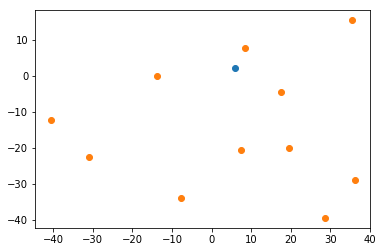

In [35]:
sigma_pos = [0.3, 0.3, 0.01]
particles = init_particles(state, sigma_pos, 10)
_ = plt.scatter(state[0], state[1])
#_ = plt.scatter(particles[:,0], particles[:,1])
obs_map = obs_in_map_coord(obs, state)
_ = plt.scatter(obs_map[:,0], obs_map[:,1])

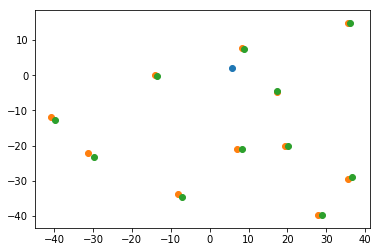

In [37]:
obs_p0 = obs_in_map_coord(obs, particles[0])
lm_p0 = landmark_in_range(50., particles[0], lm)
_ = plt.scatter(particles[0,0], particles[0, 1])
_ = plt.scatter(obs_p0[:,0], obs_p0[:,1])
_ = plt.scatter(lm_p0[:,0], lm_p0[:, 1])

In [43]:
sigma_obs = [0.3, 0.3]
w, logw = compute_weight(lm_p0, obs_p0, sigma_obs)
print(np.log(w), logw)

-59.5395598335 -59.5395598335


In [45]:
weights, logweights = particles_weights(particles, obs, lm)
print(weights)
print(weights/np.sum(weights))

[1.387706777424622e-26, 1.5854761446380213e-13, 0.00035674916577582282, 1.8054313696237609e-05, 3.0405455454991191e-18, 5.914240973807716e-29, 5.8569567001560459e-41, 5.0587200062680687e-31, 5.5755870164540958e-23, 7.9712413268352106e-19]
[  3.70249171e-23   4.23015322e-10   9.51829919e-01   4.81700803e-02
   8.11237278e-15   1.57795786e-25   1.56267405e-37   1.34969932e-27
   1.48760279e-19   2.12677890e-15]


In [49]:
p = [(0,0,0)]*10
p[0]=(6.60934,1.92143,-0.00186731)
p[1]=(6.5804,1.86864,0.00524836)
p[2]=(6.61401,1.91478,0.0190468)
p[3]=(6.5972,1.90692,0.00151721)
p[4]=(6.64363,1.89706,-0.00907155)
p[5]=(6.6365,1.8908,0.0108842)
p[6]=(6.58492,1.87772,-0.0223529)
p[7]=(6.53283,1.88525,-0.00169632)
p[8]=(6.58616,1.89536,-0.00293738)
p[9]=(6.61261,1.88052,0.00638246)
p = np.array(p)

In [51]:
weights, logweights = particles_weights(p, obs, lm)
print(weights)
print(np.exp(logweights))
print(weights/np.sum(weights))

[0.012223463390030772, 3.7972636201056574e-06, 2.7558510021950486e-22, 0.00071368808560001403, 0.011541821427127244, 3.0455908934645836e-12, 3.0348858017804798e-10, 0.04253607008121825, 0.026406943343693853, 1.6373189336144345e-07]
[  1.22234634e-02   3.79726362e-06   2.75585100e-22   7.13688086e-04
   1.15418214e-02   3.04559089e-12   3.03488580e-10   4.25360701e-02
   2.64069433e-02   1.63731893e-07]
[  1.30835851e-01   4.06446358e-05   2.94977046e-21   7.63907783e-03
   1.23539784e-01   3.25989832e-11   3.24843994e-09   4.55291824e-01
   2.82651062e-01   1.75253126e-06]
